# CS579: Lecture 13  

**Demographic Inference II**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

## Gender Classification

Let's build a classifier to predict whether a Twitter user is male/female.

We'll collect "labeled" training data using Census name list.

**1.) Collect Census names. **

In [1]:
# Fetch male/female names from Census.

import requests

def get_census_names():
    """ Fetch a list of common male/female names from the census.
    For ambiguous names, we select the more frequent gender."""
    males = requests.get('http://www2.census.gov/topics/genealogy/1990surnames/dist.male.first').text.split('\n')
    females = requests.get('http://www2.census.gov/topics/genealogy/1990surnames/dist.female.first').text.split('\n')
    males_pct = dict([(m.split()[0].lower(), float(m.split()[1]))
                  for m in males if m])
    females_pct = dict([(f.split()[0].lower(), float(f.split()[1]))
                    for f in females if f])
    male_names = set([m for m in males_pct if m not in females_pct or
                  males_pct[m] > females_pct[m]])
    female_names = set([f for f in females_pct if f not in males_pct or
                  females_pct[f] > males_pct[f]])    
    return male_names, female_names

male_names, female_names = get_census_names()
print('found %d female and %d male names' % (len(female_names), len(male_names)))
print('male name sample:', list(male_names)[:5])
print('female name sample:', list(female_names)[:5])

found 4014 female and 1146 male names
male name sample: ['daniel', 'timmy', 'federico', 'normand', 'dillon']
female name sample: ['zulma', 'yolando', 'erinn', 'alma', 'roselia']


**2.) Sample 5K tweets with names on the Census list. **

In [2]:
# Construct TwitterAPI object.

import configparser
from TwitterAPI import TwitterAPI

def get_twitter(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')

In [5]:
# Sample U.S. tweets with names from Census. 
import sys

def get_first_name(tweet):
    if 'user' in tweet and 'name' in tweet['user']:
        parts = tweet['user']['name'].split()
        if len(parts) > 0:
            return parts[0].lower()

def sample_tweets(twitter, limit, male_names, female_names):
    tweets = []
    while True:
        try:
            # Restrict to U.S.
            for response in twitter.request('statuses/filter',
                        {'locations':'-124.637,24.548,-66.993,48.9974'}):
                if 'user' in response:
                    name = get_first_name(response)
                    if name in male_names or name in female_names:
                        tweets.append(response)
                        if len(tweets) % 100 == 0:
                            print('found %d tweets' % len(tweets))
                        if len(tweets) >= limit:
                            return tweets
        except:
            print("Unexpected error:", sys.exc_info()[0])
    return tweets

In [ ]:
tweets = sample_tweets(twitter, 5000, male_names, female_names)

In [6]:
# optionally read from disk or save to disk
import pickle
tweets = pickle.load(open('tweets.pkl', 'rb'))

In [7]:
from collections import Counter

print('sampled %d tweets' % len(tweets))
print('top names:', Counter(get_first_name(t) for t in tweets).most_common(10))

sampled 5000 tweets
top names: [('john', 68), ('michael', 52), ('david', 48), ('chris', 45), ('nick', 44), ('kevin', 38), ('mark', 36), ('robert', 35), ('mike', 35), ('matt', 32)]


In [8]:
print(len(male_names), len(female_names))

1146 4014


In [6]:
# Save these tweets.
import pickle
pickle.dump(tweets, open('tweets.pkl', 'wb'))

**3.) Tokenize tweets. **

In [9]:
test_tweet = tweets[1]
print('test tweet:\n\tscreen_name=%s\n\tname=%s\n\tdescr=%s\n\ttext=%s' %
      (test_tweet['user']['screen_name'],
       test_tweet['user']['name'],
       test_tweet['user']['description'],
       test_tweet['text']))

test tweet:
	screen_name=JustinW33119287
	name=Justin Williams
	descr=Parent..Dad..friend...fan of the game.
Mac BULLDOGS #35
	text=Hell I would skip classes if I could get first team reps...#wakeup


In [10]:
import re

def tokenize(string, lowercase, keep_punctuation, prefix,
             collapse_urls, collapse_mentions):
    """ Split a tweet into tokens."""
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    if prefix:
        tokens = ['%s%s' % (prefix, t) for t in tokens]
    return tokens

In [11]:
tokenize(test_tweet['user']['description'], lowercase=True,
         keep_punctuation=False, prefix='d=',
         collapse_urls=True, collapse_mentions=True)

['d=parent',
 'd=dad',
 'd=friend',
 'd=fan',
 'd=of',
 'd=the',
 'd=game',
 'd=mac',
 'd=bulldogs',
 'd=35']

In [12]:
tokenize('apple-banana went to the store!', lowercase=True,
         keep_punctuation=False, prefix='d=',
         collapse_urls=True, collapse_mentions=True)

['d=apple', 'd=banana', 'd=went', 'd=to', 'd=the', 'd=store']

In [13]:
tokenize(test_tweet['text'], lowercase=True, keep_punctuation=True,
         prefix='t=',
         collapse_urls=True, collapse_mentions=False)

['t=hell',
 't=i',
 't=would',
 't=skip',
 't=classes',
 't=if',
 't=i',
 't=could',
 't=get',
 't=first',
 't=team',
 't=reps...#wakeup']

In [15]:
def tweet2tokens(tweet, use_descr=True, lowercase=True,
                 keep_punctuation=True, descr_prefix='d=',
                 collapse_urls=True, collapse_mentions=True):
    """ Convert a tweet into a list of tokens, from the tweet text and optionally the
    user description. """
    tokens = tokenize(tweet['text'], lowercase, keep_punctuation, None,
                       collapse_urls, collapse_mentions)
    if use_descr:
        tokens.extend(tokenize(tweet['user']['description'], lowercase,
                               keep_punctuation, descr_prefix,
                               collapse_urls, collapse_mentions))
    return tokens

In [16]:
tweet2tokens(test_tweet)

['hell',
 'i',
 'would',
 'skip',
 'classes',
 'if',
 'i',
 'could',
 'get',
 'first',
 'team',
 'reps...#wakeup',
 'd=parent..dad..friend...fan',
 'd=of',
 'd=the',
 'd=game.',
 'd=mac',
 'd=bulldogs',
 'd=#35']

In [17]:
# for enumerating all possible arguments of tweet2tokens
# https://docs.python.org/2/library/itertools.html#itertools.product
from itertools import product

use_descr_opts = [True, False]
lowercase_opts = [True, False]
keep_punctuation_opts = [True, False]
descr_prefix_opts = ['d=', '']
url_opts = [True, False]
mention_opts = [True, False]

argnames = ['use_descr', 'lower', 'punct', 'prefix', 'url', 'mention']
option_iter = product(use_descr_opts, lowercase_opts,
                       keep_punctuation_opts,
                       descr_prefix_opts, url_opts,
                       mention_opts)
for options in option_iter:
    print('  '.join('%s=%s' % (name, opt) 
                    for name, opt in zip(argnames, options)))
    print
    print('  '.join(tweet2tokens(test_tweet, *options)), '\n----\n')

use_descr=True  lower=True  punct=True  prefix=d=  url=True  mention=True
hell  i  would  skip  classes  if  i  could  get  first  team  reps...#wakeup  d=parent..dad..friend...fan  d=of  d=the  d=game.  d=mac  d=bulldogs  d=#35 
----

use_descr=True  lower=True  punct=True  prefix=d=  url=True  mention=False
hell  i  would  skip  classes  if  i  could  get  first  team  reps...#wakeup  d=parent..dad..friend...fan  d=of  d=the  d=game.  d=mac  d=bulldogs  d=#35 
----

use_descr=True  lower=True  punct=True  prefix=d=  url=False  mention=True
hell  i  would  skip  classes  if  i  could  get  first  team  reps...#wakeup  d=parent..dad..friend...fan  d=of  d=the  d=game.  d=mac  d=bulldogs  d=#35 
----

use_descr=True  lower=True  punct=True  prefix=d=  url=False  mention=False
hell  i  would  skip  classes  if  i  could  get  first  team  reps...#wakeup  d=parent..dad..friend...fan  d=of  d=the  d=game.  d=mac  d=bulldogs  d=#35 
----

use_descr=True  lower=True  punct=True  prefix=  url

In [18]:
# Let's tokenize all tweets.
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=False, descr_prefix='d=',
                            collapse_urls=True, collapse_mentions=True)
              for t in tweets]

In [19]:
tokens_list[1]

['hell',
 'i',
 'would',
 'skip',
 'classes',
 'if',
 'i',
 'could',
 'get',
 'first',
 'team',
 'reps',
 'wakeup',
 'd=parent',
 'd=dad',
 'd=friend',
 'd=fan',
 'd=of',
 'd=the',
 'd=game',
 'd=mac',
 'd=bulldogs',
 'd=35']

In [20]:
from collections import defaultdict
d = defaultdict(lambda: [])
d['cat'].append(10)
d['cat']
#v = {}
#v['cat'].append(10)

[10]

In [21]:
# Store these in a sparse matrix.

#1) Create a vocabulary (dict from term->index)

# https://docs.python.org/2/library/collections.html#collections.defaultdict
from collections import defaultdict

def make_vocabulary(tokens_list):
    vocabulary = defaultdict(lambda: len(vocabulary))  # If term not present, assign next int.
    for tokens in tokens_list:
        for token in tokens:
            vocabulary[token]  # looking up a key; defaultdict takes care of assigning it a value.
    print('%d unique terms in vocabulary' % len(vocabulary))
    return vocabulary

In [22]:
vocabulary = make_vocabulary(tokens_list)

20800 unique terms in vocabulary


In [23]:
# term->index
list(vocabulary.items())[:10]

[('THIS_IS_A_MENTION', 0),
 ('propaganda', 1),
 ('is', 2),
 ('real', 3),
 ('d=grandmother', 4),
 ('d=wife', 5),
 ('d=mother', 6),
 ('d=sister', 7),
 ('d=daughter', 8),
 ('d=and', 9)]

In [24]:
# How big is vocabulary if we keep punctuation?
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=True, descr_prefix='d=',
                            collapse_urls=True, collapse_mentions=True)
              for t in tweets]

vocabulary = make_vocabulary(tokens_list)

30485 unique terms in vocabulary


In [25]:
# How big is vocabulary if we keep punctuation and urls?
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=True, descr_prefix='d=',
                            collapse_urls=False, collapse_mentions=True)
              for t in tweets]

vocabulary = make_vocabulary(tokens_list)

32729 unique terms in vocabulary


In [26]:
# How big is vocabulary if we keep punctuation and urls and mentions?
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=True, descr_prefix='d=',
                            collapse_urls=False, collapse_mentions=False)
              for t in tweets]

vocabulary = make_vocabulary(tokens_list)

37447 unique terms in vocabulary


## Feature Vector Matrix

Create a matrix $X$ where $X[i,j]$ is the frequency of term $j$ in tweet $i$.

$$
X = \begin{pmatrix}
~ & \hbox{term}_1 & \hbox{term}_2 & \hbox{term}_3 & \hbox{term}_4 \\
\hbox{tweet}_1 & 1  &  0  &  0 & 0 \\
\hbox{tweet}_2 & 0  &  0  &  0 & 2 \\
\hbox{tweet}_3 & 1  &  1  &  0 & 0 \\
\end{pmatrix}
$$



## Sparse Matrices

$$
X = \begin{pmatrix}
~ & \hbox{term}_1 & \hbox{term}_2 & \hbox{term}_3 & \hbox{term}_4 \\
\hbox{tweet}_1 & 1  &  0  &  0 & 0 \\
\hbox{tweet}_2 & 0  &  0  &  0 & 2 \\
\hbox{tweet}_3 & 1  &  1  &  0 & 0 \\
\end{pmatrix}
$$

$X$ is mostly $0$ for text problems.

## List of List (LIL) Matrix

Store a linked list of (index, value) pairs for each row.

$$
X = \begin{pmatrix}
\hbox{tweet}_1 & (0, 1)\\
\hbox{tweet}_2 & (3,2)\\
\hbox{tweet}_3 & (0,1), (1,1)\\
\end{pmatrix}
$$

**Advantage:** Fast to construct: append to list in constant time.

**Disadvantage:** Slow random access for matrix-vector product.

E.g., $\hat{z} = X\cdot \hat{\beta}$ to classify tweets using a learned weight vector $\beta$

$\hat{z}[i] = \sum_j X[i,j] * \beta[j]$

## Compressed Sparse Row (CSR) Matrix


$$
X = \begin{pmatrix}
~ & \hbox{term}_1 & \hbox{term}_2 & \hbox{term}_3 & \hbox{term}_4 \\
\hbox{tweet}_1 & 1  &  0  &  0 & 0 \\
\hbox{tweet}_2 & 0  &  0  &  0 & 2 \\
\hbox{tweet}_3 & 1  &  1  &  0 & 0 \\
\hbox{tweet}_4 & 1  &  0  &  0 & 0 \\
\end{pmatrix}
$$

CSR Matrix is an object with three attributes: 
- **val:** $\{1,2,1,1,1\}$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *list of all non-zero values*  
- **col_ind:** $\{0,3,0,1,0\}$ &nbsp; *column index for each non-zero value* (e.g., first non-zero value (1) is in column 0) 
- **row_ptr:** $\{0,1,2,4\}$ &nbsp;&nbsp;&nbsp; *index into **col_ind** where each row starts* (e.g., tweet3, term1 corresponds to col_ind[2])

Allows efficient row access (good for us, since each row is a tweet)

In [27]:
# Convert features to a sparse matrix X.
# X[i,j] is the frequency of term j in tweet i
# 
from scipy.sparse import lil_matrix

def make_feature_matrix(tokens_list, vocabulary):
    X = lil_matrix((len(tweets), len(vocabulary)))
    for i, tokens in enumerate(tokens_list):
        for token in tokens:
            j = vocabulary[token]
            X[i,j] += 1
    return X.tocsr()  # convert to CSR for more efficient random access.

In [28]:
X = make_feature_matrix(tokens_list, vocabulary)
print('shape of X:', X.shape)

shape of X: (5000, 37447)


In [29]:
help(X)

Help on csr_matrix in module scipy.sparse.csr object:

class csr_matrix(scipy.sparse.compressed._cs_matrix, scipy.sparse.sputils.IndexMixin)
 |  csr_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indp

In [30]:
# How is tweet stored?
X[1]

<1x37447 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [56]:
help(X[1])

Help on csr_matrix in module scipy.sparse.csr object:

class csr_matrix(scipy.sparse.compressed._cs_matrix, scipy.sparse.sputils.IndexMixin)
 |  csr_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indp

In [57]:
X[1].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([15, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36], dtype=int32))

In [58]:
# non-zero indices of terms used in tweet 1.
X[1].nonzero()[1]  # col_ind

array([15, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36], dtype=int32)

In [60]:
vocabulary

defaultdict(<function __main__.make_vocabulary.<locals>.<lambda>()>,
            {'@dgpurser': 0,
             'propaganda': 1,
             'is': 2,
             'real': 3,
             '😡': 4,
             'd=grandmother,': 5,
             'd=wife,': 6,
             'd=mother,': 7,
             'd=sister,': 8,
             'd=daughter': 9,
             'd=and': 10,
             'd=a': 11,
             'd=good': 12,
             'd=friend.': 13,
             'd=love': 14,
             'd=the': 15,
             'd=usa!': 16,
             'd=trump!': 17,
             'd=jesus!': 18,
             'd=#maga': 19,
             'hell': 20,
             'i': 21,
             'would': 22,
             'skip': 23,
             'classes': 24,
             'if': 25,
             'could': 26,
             'get': 27,
             'first': 28,
             'team': 29,
             'reps...#wakeup': 30,
             'd=parent..dad..friend...fan': 31,
             'd=of': 32,
             'd=game.': 3

In [59]:
# term counts for tweet 1.
X[1].data  # "val"

array([1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [61]:
# What word does each term index correspond to?
# Convert term->index dict into index->term dict
index2term = {i: t for t, i in vocabulary.items()}
print(index2term[15])
print(X[1, 15])
# So, the term "the" (index 15) appears in user 200's tweet one time

d=the
1.0


In [62]:
# i appears two times.
print(index2term[21])
print(X[1, 21])

i
2.0


In [63]:
tweets[1]

{'created_at': 'Wed Mar 06 15:33:44 +0000 2019',
 'id': 1103317748879368193,
 'id_str': '1103317748879368193',
 'text': 'Hell I would skip classes if I could get first team reps...#wakeup',
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 899396442510503936,
  'id_str': '899396442510503936',
  'name': 'Justin Williams',
  'screen_name': 'JustinW33119287',
  'location': None,
  'url': None,
  'description': 'Parent..Dad..friend...fan of the game.\nMac BULLDOGS #35',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 10,
  'friends_count': 139,
  'listed_count': 0,
  'favourites_count': 81,
  'statuses_count': 34,
  'created_at': 'Sun Aug 20 22:23:16 +0000 2017',
  'utc_offset': None,
  'time_zone'

How do CSR matrices access row values?

Recall:

CSR Matrix is an object with three attributes: 
- **val:** $\{1,2,1,1\}$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *list of all non-zero values*  
- **col_ind:** $\{0,3,0,1\}$ &nbsp; *column index for each non-zero value* (e.g., first non-zero value (1) is in column 0) 
- **row_ptr (ind_ptr):** $\{0,1,2\}$ &nbsp;&nbsp;&nbsp; *index into **col_ind** where each row starts* (e.g., tweet3, term1 corresponds to col_ind[2])

In [37]:
# Recall: numpy array slices.
import numpy as np
a = np.array([0, 100, 200, 300, 400, 500])
a[2:5]  # get elements at positions 2,3,4

array([200, 300, 400])

In [64]:
print('tweet 1 starts at col_ind=', X.indptr[1])
print('tweet 2 starts at col_ind=', X.indptr[2])
print('so, the columns that are non-zero for tweet 1 are:')
print(X.indices[X.indptr[1]:X.indptr[2]])
print('and the data associated with those cells are:')
print(X.data[X.indptr[1]:X.indptr[2]])

tweet 1 starts at col_ind= 20
tweet 2 starts at col_ind= 38
so, the columns that are non-zero for tweet 1 are:
[15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
and the data associated with those cells are:
[1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
print('tweet 0:\n', X[0], '\n')
print('tweet 1:\n', X[1], '\n')
print('tweet 2:\n', X[2])

tweet 0:
   (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	3.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0 

tweet 1:
   (0, 15)	1.0
  (0, 20)	1.0
  (0, 21)	2.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	1.0
  (0, 30)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (0, 33)	1.0
  (0, 34)	1.0
  (0, 35)	1.0
  (0, 36)	1.0 

tweet 2:
   (0, 11)	1.0
  (0, 15)	1.0
  (0, 32)	2.0
  (0, 37)	1.0
  (0, 38)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 43)	1.0
  (0, 44)	1.0
  (0, 45)	1.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 48)	1.0
  (0, 49)	1.0
  (0, 50)	1.0
  (0, 51)	1.0
  (0, 52)	1.0
  (0, 53)	1.0
  (0, 54)	1.0
  (0, 55)	1.0
  (0, 56)	1.0
  (0, 57)	1.0
  (0, 58)	1.0
  (0, 59)	1.0
  (0, 60)	1.0
  (0, 61)	1.0
  (0, 62)	1.0
  (0, 63)	1.0
  (0, 64)	1.0
  (0, 65)	

**Efficient matrix vector product:**

$$ z = X * \beta $$

In [40]:
# Compute z = X * \beta, where X is a CSR matrix.
import numpy as np
beta = np.ones(len(vocabulary))  # assume Beta = vector of 1s
z = np.zeros(len(tweets))
for i in range(len(tweets)):  # for each row.
    for j in range(X.indptr[i], X.indptr[i+1]): # for each col.
        colidx = X.indices[j]
        z[i] += beta[colidx] * X.data[j]
print('X * beta for tweet 1=', z[1])
print('which is the same as the sum %.1f, since beta=[1...1]' %
      X[1].sum())

X * beta for tweet 1= 19.0
which is the same as the sum 19.0, since beta=[1...1]


**4.) Create a list of gender labels.**

In [41]:
# y is a 1d numpy array of gender labels.
# Let 1=Female, 0=Male.
import numpy as np

def get_gender(tweet, male_names, female_names):
    name = get_first_name(tweet)
    if name in female_names:
        return 1
    elif name in male_names:
        return 0
    else:
        return -1
    
y = np.array([get_gender(t, male_names, female_names) for t in tweets])
print('gender labels:', Counter(y))

gender labels: Counter({0: 2864, 1: 2136})


**5.) Fit a Logistic Regression classifier to predict gender from profile/tweet.**

In [42]:
# Do 5-fold cross-validation
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def do_cross_val(X, y, nfolds):
    """ Compute average cross-validation acccuracy."""
    cv = KFold(n_splits=nfolds, random_state=42, shuffle=True)
    accuracies = []
    for train_idx, test_idx in cv.split(X):
        clf = LogisticRegression()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    print(np.std(accuracies))
    print(accuracies)
    return avg

In [43]:
print('avg accuracy', do_cross_val(X, y, 5))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.011943198901466903
[0.737, 0.713, 0.727, 0.718, 0.702]
avg accuracy 0.7194


In [44]:
# Fitting model with CSR much, much faster than with LIL.
from timeit import timeit
print('CSR TIME')
timeit("do_cross_val(X.tocsr(), y, 2)", number=5,
       setup="from __main__ import do_cross_val, X, y")

CSR TIME
0.0010000000000000009
[0.6976, 0.6956]
0.0010000000000000009
[0.6976, 0.6956]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0010000000000000009
[0.6976, 0.6956]
0.0010000000000000009
[0.6976, 0.6956]
0.0010000000000000009
[0.6976, 0.6956]


0.44832760699999596

In [45]:
print('LIL TIME')
timeit("do_cross_val(X.tolil(), y, 2)", number=5,
       setup="from __main__ import do_cross_val, X, y")

LIL TIME
0.0010000000000000009
[0.6976, 0.6956]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0010000000000000009
[0.6976, 0.6956]
0.0010000000000000009
[0.6976, 0.6956]
0.0010000000000000009
[0.6976, 0.6956]
0.0010000000000000009
[0.6976, 0.6956]


1.0048618020000077

(See more about vectorization of arithmetic operations: 
https://en.wikipedia.org/wiki/Automatic_vectorization )

In [46]:
# How does tokenization affect accuracy?
# Collapse urls and mentions; ignore description prefix.
def run_all(tweets, use_descr=True, lowercase=True,
            keep_punctuation=True, descr_prefix=None,
            collapse_urls=True, collapse_mentions=True):
    
    tokens_list = [tweet2tokens(t, use_descr, lowercase,
                            keep_punctuation, descr_prefix,
                            collapse_urls, collapse_mentions)
                  for t in tweets]
    vocabulary = make_vocabulary(tokens_list)
    X = make_feature_matrix(tokens_list, vocabulary)
    acc = do_cross_val(X, y, 5)
    print('acc=', acc)
    return acc

In [47]:
argnames = ['use_descr', 'lower', 'punct', 'prefix', 'url', 'mention']
option_iter = product(use_descr_opts, lowercase_opts,
                       keep_punctuation_opts,
                       descr_prefix_opts, url_opts,
                       mention_opts)
results = []
for options in option_iter:
    option_str = '\t'.join('%s=%s' % (name, opt) for name, opt
                           in zip(argnames, options))
    print(option_str)
    acc = run_all(tweets, *options)
    results.append((acc, options))
    print

use_descr=True	lower=True	punct=True	prefix=d=	url=True	mention=True
30485 unique terms in vocabulary


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0150651916682132
[0.744, 0.71, 0.723, 0.723, 0.699]
acc= 0.7198
use_descr=True	lower=True	punct=True	prefix=d=	url=True	mention=False
35203 unique terms in vocabulary
0.01149956520917205
[0.735, 0.71, 0.725, 0.72, 0.702]
acc= 0.7183999999999999
use_descr=True	lower=True	punct=True	prefix=d=	url=False	mention=True
32729 unique terms in vocabulary
0.012939860895697462
[0.741, 0.714, 0.72, 0.721, 0.701]
acc= 0.7194
use_descr=True	lower=True	punct=True	prefix=d=	url=False	mention=False
37447 unique terms in vocabulary
0.011943198901466903
[0.737, 0.713, 0.727, 0.718, 0.702]
acc= 0.7194
use_descr=True	lower=True	punct=True	prefix=	url=True	mention=True
26770 unique terms in vocabulary
0.013638181696985868
[0.754, 0.732, 0.721, 0.723, 0.715]
acc= 0.7289999999999999
use_descr=True	lower=True	punct=True	prefix=	url=True	mention=False
31440 unique terms in vocabulary
0.011949895397031736
[0.753, 0.726, 0.727, 0.726, 0.718]
acc= 0.73
use_descr=True	lower=True	punct=True	prefix=	url=False	menti

0.014913081505845771
[0.592, 0.584, 0.598, 0.598, 0.558]
acc= 0.586
use_descr=False	lower=False	punct=True	prefix=d=	url=True	mention=True
16516 unique terms in vocabulary
0.01626775952613018
[0.579, 0.561, 0.571, 0.605, 0.561]
acc= 0.5753999999999999
use_descr=False	lower=False	punct=True	prefix=d=	url=True	mention=False
20151 unique terms in vocabulary
0.01749742838247954
[0.593, 0.579, 0.588, 0.625, 0.576]
acc= 0.5922
use_descr=False	lower=False	punct=True	prefix=d=	url=False	mention=True
18580 unique terms in vocabulary
0.015730225681788522
[0.573, 0.56, 0.576, 0.603, 0.56]
acc= 0.5744
use_descr=False	lower=False	punct=True	prefix=d=	url=False	mention=False
22215 unique terms in vocabulary
0.01819450466487067
[0.592, 0.575, 0.588, 0.622, 0.57]
acc= 0.5893999999999999
use_descr=False	lower=False	punct=True	prefix=	url=True	mention=True
16516 unique terms in vocabulary
0.01626775952613018
[0.579, 0.561, 0.571, 0.605, 0.561]
acc= 0.5753999999999999
use_descr=False	lower=False	punct=Tr

In [48]:
for r in sorted(results, reverse=True):
    print('%.4f' % r[0], '  '.join('%s=%s' % (name, opt) for name, opt in zip(argnames, r[1])))

0.7350 use_descr=True  lower=True  punct=False  prefix=  url=False  mention=False
0.7344 use_descr=True  lower=True  punct=False  prefix=  url=True  mention=False
0.7308 use_descr=True  lower=True  punct=False  prefix=  url=False  mention=True
0.7300 use_descr=True  lower=True  punct=True  prefix=  url=True  mention=False
0.7298 use_descr=True  lower=True  punct=False  prefix=  url=True  mention=True
0.7290 use_descr=True  lower=True  punct=True  prefix=  url=True  mention=True
0.7290 use_descr=True  lower=True  punct=False  prefix=d=  url=True  mention=False
0.7288 use_descr=True  lower=True  punct=False  prefix=d=  url=False  mention=False
0.7284 use_descr=True  lower=False  punct=False  prefix=d=  url=False  mention=False
0.7284 use_descr=True  lower=True  punct=True  prefix=  url=False  mention=False
0.7280 use_descr=True  lower=False  punct=False  prefix=d=  url=True  mention=False
0.7276 use_descr=True  lower=False  punct=False  prefix=d=  url=True  mention=True
0.7270 use_descr=

In [49]:
idx2word = dict((v,k) for k,v in vocabulary.items())

In [50]:
# Fit model on all data and print top coef.
model = LogisticRegression()
model.fit(X,y)
# Get the learned coefficients for the Positive class.
coef = model.coef_[0]
# Sort them in descending order.
top_coef_ind = np.argsort(coef)[::-1][:20]
# Get the names of those features.
top_coef_terms = [idx2word[i] for i in top_coef_ind]
# Get the weights of those features
top_coef = coef[top_coef_ind]
# Print the top 10.
print('top weighted terms for female class:')
print('\n'.join(str(x) for x in zip(top_coef_terms, top_coef)))

# repeat for males
top_coef_ind = np.argsort(coef)[:20]
top_coef_terms = [idx2word[i] for i in top_coef_ind]
top_coef = coef[top_coef_ind]
print('\ntop weighted terms for male class:')
print('\n'.join(str(x) for x in zip(top_coef_terms, top_coef)))


top weighted terms for female class:
('d=mom', 2.293617303859181)
('d=mom,', 2.0488392184164397)
('d=mother,', 1.4518141062351255)
('d=✨', 1.3680955382868738)
('d=girl', 1.299086742000796)
('d=mother', 1.2891725957620639)
('d=cat', 1.2519720364367304)
('d=mom.', 1.1736630261706469)
('d=enthusiast,', 1.1249967928568936)
('d=physician,', 1.0427912382991138)
('d=nurse', 1.027741796967544)
('d=wife,', 1.005656836318468)
('d=marketing', 1.0008923585403477)
('life', 0.9968594358119716)
('d=grade', 0.9704895579402542)
('d=she', 0.9679212970365512)
('d=fuck', 0.9449276361530612)
('@thedemocrats', 0.9423405652966773)
('omg', 0.9409557228225768)
('d=alumna', 0.9384186729428542)

top weighted terms for male class:
('d=guy', -1.493104934655252)
('d=sports', -1.4708465227875436)
('d=father', -1.4585359733423064)
('d=husband', -1.1942375899133295)
('d=man', -1.174928533602881)
('d=dad', -1.1355436456657324)
('d=army', -1.086052145908333)
('d=father,', -1.0444930930939456)
('d=eclectic', -1.039265763

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


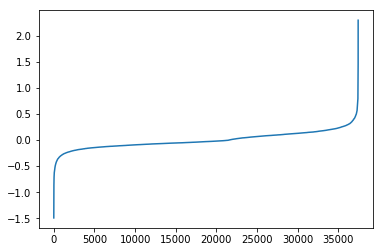

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(sorted(coef))
plt.show()

In [52]:
coef[vocabulary['dress']]

-0.17694311780110938

In [53]:
coef[vocabulary['she']]

0.4305670349226093

In [54]:
coef[vocabulary['he']]

-0.05792589898629376

In [55]:
coef[vocabulary['the']]  # ?

-0.10897637658319169

## Error Analysis

- Which ones do we get wrong?
- Are there obvious reasons?